# Machine Learning for Complete Intersection Calabi-Yau Manifolds

After the preanalysis and the **feature selection**, we no proceed with the ML analysis using different algorithms to evaluate the best predictions for the **Hodge numbers** of CICY 3-folds. We first print debug information on the system and then load the previously generated datasets. We then move to the analysis using _Scikit-learn_ as reference library. In particular we use:

- [LinearRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html#sklearn.linear_model.LinearRegression) to have a starting point,
- [Lasso](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html#sklearn.linear_model.Lasso) to check the difference from the linear model using a **L1** regularization,
- [Ridge](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html#sklearn.linear_model.Ridge) to implement **L2** regularization to the linear model,
- [ElasticNet](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNet.html#sklearn.linear_model.ElasticNet) to see whether **L1** and **L2** can be implemented together,
- [LinearSVR](https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVR.html#sklearn.svm.LinearSVR) to implement **support vectors** with a linear kernel,
- [SVR (with Gaussian kernel)](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVR.html#sklearn.svm.SVR) to introduce a kernel function,
- [RandomForestRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html#sklearn.ensemble.RandomForestRegressor) to use forests of **decision trees** for the predictions,
- [GradientBoostingRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html#sklearn.ensemble.GradientBoostingRegressor) to boost single decision trees using gradient descent (in this case we will also study the **learning curve**).

Recently _Scikit_ has also release an improved version (though still **experimental**) of boosted trees inspired by [LightGBM](https://github.com/Microsoft/LightGBM). We will also try to implement this [HistGradientBoostingRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.HistGradientBoostingRegressor.html#sklearn.ensemble.HistGradientBoostingRegressor) since it should be faster (histogram based models are in general a good choice when the number of samples is larger than 10000, which is not our case, but we are near that threashold) and it has native support for missing values (`NaN` gradients) just in case we encounter them. Moreover it resembles closely the [XGBoost](https://xgboost.readthedocs.io/en/latest/) implementation which we will not cover.

## Infrastructure

We print information about the current OS:

In [1]:
from mltools.libos import InfoOS

print('Current OS:                  {} (kernel release: {}, architecture: {})'.format(InfoOS().os, InfoOS().kernel, InfoOS().arch))
print('Number of available threads: {:d}'.format(InfoOS().threads))
print('Current CPU frequency:       {:.0f} MHz (max: {:.0f} MHz)'.format(InfoOS().freq, InfoOS().freqm))
print('Available RAM memory:        {:d} MB (tot: {:d} MB)'.format(InfoOS().vmav, InfoOS().vmtot))

Current OS:                  Linux (kernel release: 5.6.6-arch1-1, architecture: x86_64)
Number of available threads: 8
Current CPU frequency:       3440 MHz (max: 3800 MHz)
Available RAM memory:        9031 MB (tot: 15758 MB)


We then print information on the current GPU setup (if available):

In [2]:
!nvidia-smi

Thu Apr 23 20:58:40 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 440.82       CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce 940MX       Off  | 00000000:02:00.0 Off |                  N/A |
| N/A   38C    P8    N/A /  N/A |     37MiB /  2004MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

## Setup

We import the Python modules we use and print their versions to keep track of changes.

In [3]:
import sys

import matplotlib as mpl
import random     as rnd
import sklearn    as skl
import skopt      as sko
import numpy      as np
import pandas     as pd
import tensorflow as tf

from tensorflow       import keras
from tensorflow.keras import backend as K

import warnings
warnings.simplefilter(action='ignore', category=UserWarning) # ignore user warnings: nothing that I can really do anything about it...

%matplotlib inline
mpl.rc('axes', labelsize=12)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# print the version of the modules
print('Python version: {:d}.{:d}'      .format(sys.version_info.major, sys.version_info.minor))
print('Matplot version: {}'            .format(mpl.__version__))
print('Numpy version: {}'              .format(np.__version__))
print('Pandas version: {}'             .format(pd.__version__))
print('Scikit-learn version: {}'       .format(skl.__version__))
print('Scikit-optimize version: {}'    .format(sko.__version__))
print('Tensorflow version: {}'         .format(tf.__version__))
print('Keras version: {} (backend: {})'.format(keras.__version__, K.backend()))

# fix random_seed
RAND = 42
rnd.seed(RAND)
np.random.seed(RAND)
tf.random.set_seed(RAND)

Python version: 3.7
Matplot version: 3.2.1
Numpy version: 1.18.1
Pandas version: 1.0.3
Scikit-learn version: 0.22.2.post1
Scikit-optimize version: 0.7.4
Tensorflow version: 2.0.0
Keras version: 2.2.4-tf (backend: tensorflow)


We finally set the _memory growth_ property of the GPU in order to avoid overflowing its RAM memory:

In [4]:
gpus = tf.config.experimental.list_physical_devices('GPU') #--------------------------------------- list of physical GPUs

if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True) #---------------------------------- set memory growth
            
        logical_gpus = tf.config.experimental.list_logical_devices('GPU') #------------------------ list of logical devices
        print('GPU setup: {:d} physical GPUs, {:d} logical GPUs.'.format(len(gpus),
                                                                         len(logical_gpus)
                                                                        )
             )
    except RuntimeError as e:
        print(e)
else:
    print('No GPUs in the setup!')

GPU setup: 1 physical GPUs, 1 logical GPUs.


## Session Preparation

in order to save the results of the analysis, we define where to store images, log files and models:

In [5]:
from os import path, makedirs

ROOT_DIR = '.' #-------------------------------------------------- root directory
IMG_DIR  = 'img' #------------------------------------------------ directory of images
MOD_DIR  = 'models' #--------------------------------------------- directory of saved models
LOG_DIR  = 'log' #------------------------------------------------ directory of logs

DB_NAME = 'cicy3o' #---------------------------------------------- name of the dataset
DB_FILE = DB_NAME + '.h5' #--------------------------------------- full name with extension
DB_PATH = path.join(ROOT_DIR, DB_FILE) #-------------------------- full path of the dataset
DB_DIR  = 'original' if DB_NAME == 'cicy3o' else 'favourable' #--- subdir where to store images, models, logs

# define full paths
IMG_PATH = path.join(ROOT_DIR, IMG_DIR, DB_DIR)
MOD_PATH = path.join(ROOT_DIR, MOD_DIR, DB_DIR)
LOG_PATH = path.join(ROOT_DIR, LOG_DIR, DB_DIR)

# create directories if non existent
if not path.isdir(IMG_PATH):
    makedirs(IMG_PATH, exist_ok=True)
if not path.isdir(MOD_PATH):
    makedirs(MOD_PATH, exist_ok=True)
if not path.isdir(LOG_PATH):
    makedirs(LOG_PATH, exist_ok=True)

We also create a log file to store information and results:

In [6]:
import logging

from mltools.liblog import create_logfile

log = create_logfile(path.join(LOG_PATH, DB_NAME + '_ml.log'),
                     name='CICY3',
                     level=logging.DEBUG
                    )

log.debug('New log file: session started.')

Rotating existing logs...


## Loading the Datasets

We now load the previously produced datasets and prepare them for the analysis.

N.B.: the dataset is already shuffled.

In [7]:
import joblib

# load the matrix dataset
if path.isfile(path.join(ROOT_DIR, DB_NAME + '_matrix.joblib.xz')):
    matrix = joblib.load(path.join(ROOT_DIR, DB_NAME + '_matrix.joblib.xz'))
    log.debug('Matrix loaded from file.')
else:
    print('Cannot find matrix dataset!')
    log.error('Unable to locate matrix dataset. Run the preanalysis notebook!')
    
# load the pca dataset
if path.isfile(path.join(ROOT_DIR, DB_NAME + '_pca.joblib.xz')):
    pca = joblib.load(path.join(ROOT_DIR, DB_NAME + '_pca.joblib.xz'))
    log.debug('PCA loaded from file.')
else:
    print('Cannot find PCA dataset!')
    log.error('Unable to locate PCA dataset. Run the preanalysis notebook!')
    
# load the engineered features (with the labels)
if path.isfile(path.join(ROOT_DIR, DB_NAME + '_selection.joblib.xz')):
    features = joblib.load(path.join(ROOT_DIR, DB_NAME + '_selection.joblib.xz'))
    log.debug('Engineered features loaded from file.')
else:
    print('Cannot find the dataset with the engineered features!')
    log.error('Unable to locate engineered features dataset. Run the preanalysis notebook!')

We then extract the needed features (flattened or not) since they may come in handy as separate variables:

In [8]:
from mltools.libtransformer import ExtractTensor

num_cp      = features['num_cp'].values
dim_cp      = np.array(ExtractTensor(flatten=True).fit_transform(features['dim_cp']))
dim_h0_amb  = np.array(ExtractTensor(flatten=True).fit_transform(features['dim_h0_amb']))
matrix_flat = np.array(ExtractTensor(flatten=True).fit_transform(matrix))
h11         = features['h11'].values
h21         = features['h21'].values

log.debug('Features have been extracted.')

As previously commented in the previous notebook, we will perform the following analysis:

- `matrix_flat` to predict $h_{11}$ and $h_{21}$
- `num_cp`, `dim_cp` to predict $h_{11}$, and `num_cp`, `dim_cp`, `dim_h0_amb` to predict $h_{21}$
- the previous features and `pca` to predict $h_{11}$, and the previous features and `pca` to predict $h_{21}$

We therefore build separate variables to avoid confusion during training:

In [9]:
# build selection with only engineered features
selection_h11 = np.c_[num_cp, dim_cp]
selection_h21 = np.c_[num_cp, dim_cp, dim_h0_amb]

# build feature engineered set with the pca
features_h11  = np.c_[num_cp, dim_cp, pca]
features_h21  = np.c_[num_cp, dim_cp, dim_h0_amb, pca]

## Cross Validation Strategy

We then prepare the input for training: we keep 10% of the total set as **test set**, and we split the remaining 90% into 9 different splits which we use for **cross validation** using the **K Fold** method. Therefore we will have, at all stages of validation, 10% of samples as separate test set, 10% of samples as validation set and 80% of samples as **training set**.

In [10]:
from sklearn.model_selection import KFold, train_test_split

cv = KFold(n_splits=9, shuffle=False)

matrix_train, matrix_test, \
selection_h11_train, selection_h11_test, \
selection_h21_train, selection_h21_test, \
features_h11_train, features_h11_test, \
features_h21_train, features_h21_test, \
h11_train, h11_test, \
h21_train, h21_test = train_test_split(matrix_flat,
                                       selection_h11,
                                       selection_h21,
                                       features_h11,
                                       features_h21,
                                       h11,
                                       h21,
                                       test_size=0.1,
                                       shuffle=False
                                      )

## Linear Regression

We can now move to the analysis of the algorithms. We start from a simple linear regression which has only two tunable hypeparameters, namely _fit_intercept_ and _normalize_. In order to choose the best viable option, we use a **grid search** to check all possible combinations:

- _fit_intercept_: True/False,
- _normalize_: True/False.


MATRIX

    Best parameters for h11: {'fit_intercept': True, 'normalize': True}
    Accuracy on cross validation for h11: 51.238% ± 1.227%
    Accuracy on the test set for h11: 48.728%

    Best parameters for h21: {'fit_intercept': True, 'normalize': False}
    Accuracy on cross validation for h21: 11.536% ± 1.094%
    Accuracy on the test set for h21: 9.160%


ENGINEERED FEATURES ONLY

    Best parameters for h11: {'fit_intercept': True, 'normalize': False}
    Accuracy on cross validation for h11: 52.654% ± 1.359%
    Accuracy on the test set for h11: 52.036%

    Best parameters for h21: {'fit_intercept': True, 'normalize': False}
    Accuracy on cross validation for h21: 18.217% ± 1.263%
    Accuracy on the test set for h21: 19.338%


FULL DATASET

    Best parameters for h11: {'fit_intercept': True, 'normalize': False}
    Accuracy on cross validation for h11: 52.385% ± 1.130%
    Accuracy on the test set for h11: 51.781%

    Best parameters for h21: {'fit_intercept': False, 'n

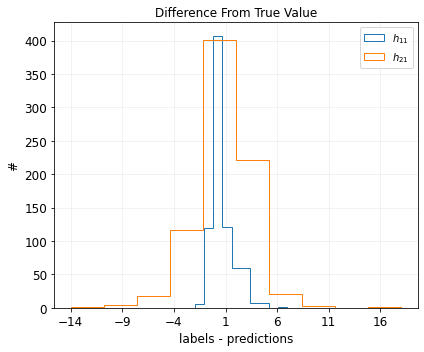

In [11]:
from sklearn.linear_model    import LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics         import make_scorer
from mltools.libscore        import accuracy, Score, ViewCV
from mltools.libplot         import Plot

log.info('Training LINEAR REGRESSION.')

rounding = np.floor #----------------------------------------- choose a rounding function
scoring  = make_scorer(accuracy, rounding=rounding) #--------- create a scoring function

params  = {'fit_intercept': [False, True],
           'normalize':     [False, True]
          } #------------------------------------------------- build the parameter space
hyper_search = GridSearchCV(LinearRegression(),
                            params,
                            scoring=scoring,
                            n_jobs=-1,
                            refit=True,
                            cv=cv) #-------------------------- define hyperparameter tuning

#############################
#                           #
# MATRIX ONLY               #
#                           #
#############################
print('\nMATRIX')
log.info('Training on the matrix dataset.')

hyper_search.fit(matrix_train, h11_train) #------------------------------------------------------- fit matrix on h11

results = ViewCV(hyper_search) #-------------------------------------------------------------------------- read CV results
print('\n    Best parameters for h11: {}'.format(results.best_parameters))
log.info('Best parameters for h11: {}'.format(results.best_parameters)) #--------------------------------- print CV parameters
print('    Accuracy on cross validation for h11: {:.3f}% ± {:.3f}%'.format(results.test_mean()*100,
                                                                         results.test_std()*100
                                                                        )
     )
log.info('Accuracy on CV for h11: {:.3f}% ± {:.3f}%'.format(results.test_mean()*100,
                                                          results.test_std()*100
                                                         )
        ) #----------------------------------------------------------------------------------------------- evaluate CV results

predictions = hyper_search.best_estimator_.predict(matrix_test) #----------------------------------------- compute predictions
pred_score_h11  = Score(h11_test, predictions, rounding=rounding)
log.info('Number of correct test predictions for h11: {:d}'.format(pred_score_h11.correct()))
log.info('Accuracy of test predictions for h11: {:.3f}%'.format(pred_score_h11.accuracy()*100))
print('    Accuracy on the test set for h11: {:.3f}%'.format(pred_score_h11.accuracy()*100)) #------------- evaluate predictions

joblib.dump(hyper_search.best_estimator_, path.join(MOD_PATH, 'lin_reg_mat_h11.joblib')) #---------------- save the model

hyper_search.fit(matrix_train, h21_train) #------------------------------------------------------- fit matrix on h21

results = ViewCV(hyper_search) #-------------------------------------------------------------------------- read CV results
print('\n    Best parameters for h21: {}'.format(results.best_parameters))
log.info('Best parameters for h21: {}'.format(results.best_parameters)) #--------------------------------- print CV parameters
print('    Accuracy on cross validation for h21: {:.3f}% ± {:.3f}%'.format(results.test_mean()*100,
                                                                         results.test_std()*100
                                                                        )
     )
log.info('Accuracy on CV for h21: {:.3f}% ± {:.3f}%'.format(results.test_mean()*100,
                                                          results.test_std()*100
                                                         )
        ) #----------------------------------------------------------------------------------------------- evaluate CV results

predictions = hyper_search.best_estimator_.predict(matrix_test) #----------------------------------------- compute predictions
pred_score_h21  = Score(h21_test, predictions, rounding=rounding)
log.info('Number of correct test predictions for h21: {:d}'.format(pred_score_h21.correct()))
log.info('Accuracy of test predictions for h21: {:.3f}%'.format(pred_score_h21.accuracy()*100))
print('    Accuracy on the test set for h21: {:.3f}%\n'.format(pred_score_h21.accuracy()*100)) #---------- evaluate predictions

joblib.dump(hyper_search.best_estimator_, path.join(MOD_PATH, 'lin_reg_mat_h21.joblib')) #---------------- save the model

#############################
#                           #
# ENGINEERED FEATURES       #
#                           #
#############################
print('\nENGINEERED FEATURES ONLY')
log.info('Training on the engineered features.')

hyper_search.fit(selection_h11_train, h11_train) #------------------------------------------------ fit set on h11

results = ViewCV(hyper_search) #-------------------------------------------------------------------------- read CV results
print('\n    Best parameters for h11: {}'.format(results.best_parameters))
log.info('Best parameters for h11: {}'.format(results.best_parameters)) #--------------------------------- print CV parameters
print('    Accuracy on cross validation for h11: {:.3f}% ± {:.3f}%'.format(results.test_mean()*100,
                                                                         results.test_std()*100
                                                                        )
     )
log.info('Accuracy on CV for h11: {:.3f}% ± {:.3f}%'.format(results.test_mean()*100,
                                                          results.test_std()*100
                                                         )
        ) #----------------------------------------------------------------------------------------------- evaluate CV results

predictions = hyper_search.best_estimator_.predict(selection_h11_test) #---------------------------------- compute predictions
pred_score_h11  = Score(h11_test, predictions, rounding=rounding)
log.info('Number of correct test predictions for h11: {:d}'.format(pred_score_h11.correct()))
log.info('Accuracy of test predictions for h11: {:.3f}%'.format(pred_score_h11.accuracy()*100))
print('    Accuracy on the test set for h11: {:.3f}%'.format(pred_score_h11.accuracy()*100)) #------------ evaluate predictions

joblib.dump(hyper_search.best_estimator_, path.join(MOD_PATH, 'lin_reg_sel_h11.joblib')) #---------------- save the model

hyper_search.fit(selection_h21_train, h21_train) #------------------------------------------------ fit set on h21

results = ViewCV(hyper_search) #-------------------------------------------------------------------------- read CV results
print('\n    Best parameters for h21: {}'.format(results.best_parameters))
log.info('Best parameters for h21: {}'.format(results.best_parameters)) #--------------------------------- print CV parameters
print('    Accuracy on cross validation for h21: {:.3f}% ± {:.3f}%'.format(results.test_mean()*100,
                                                                         results.test_std()*100
                                                                        )
     )
log.info('Accuracy on CV for h21: {:.3f}% ± {:.3f}%'.format(results.test_mean()*100,
                                                          results.test_std()*100
                                                         )
        ) #----------------------------------------------------------------------------------------------- evaluate CV results

predictions = hyper_search.best_estimator_.predict(selection_h21_test) #---------------------------------- compute predictions
pred_score_h21  = Score(h21_test, predictions, rounding=rounding)
log.info('Number of correct test predictions for h21: {:d}'.format(pred_score_h21.correct()))
log.info('Accuracy of test predictions for h21: {:.3f}%'.format(pred_score_h21.accuracy()*100))
print('    Accuracy on the test set for h21: {:.3f}%\n'.format(pred_score_h21.accuracy()*100)) #---------- evaluate predictions

joblib.dump(hyper_search.best_estimator_, path.join(MOD_PATH, 'lin_reg_sel_h21.joblib')) #---------------- save the model

#############################
#                           #
# FULL DATASET              #
#                           #
#############################
print('\nFULL DATASET')
log.info('Training on the full dataset.')

hyper_search.fit(features_h11_train, h11_train) #------------------------------------------------- fit set on h11

results = ViewCV(hyper_search) #-------------------------------------------------------------------------- read CV results
print('\n    Best parameters for h11: {}'.format(results.best_parameters))
log.info('Best parameters for h11: {}'.format(results.best_parameters)) #--------------------------------- print CV parameters
print('    Accuracy on cross validation for h11: {:.3f}% ± {:.3f}%'.format(results.test_mean()*100,
                                                                         results.test_std()*100
                                                                        )
     )
log.info('Accuracy on CV for h11: {:.3f}% ± {:.3f}%'.format(results.test_mean()*100,
                                                          results.test_std()*100
                                                         )
        ) #----------------------------------------------------------------------------------------------- evaluate CV results

predictions = hyper_search.best_estimator_.predict(features_h11_test) #----------------------------------- compute predictions
pred_score_h11  = Score(h11_test, predictions, rounding=rounding)
log.info('Number of correct test predictions for h11: {:d}'.format(pred_score_h11.correct()))
log.info('Accuracy of test predictions for h11: {:.3f}%'.format(pred_score_h11.accuracy()*100))
print('    Accuracy on the test set for h11: {:.3f}%'.format(pred_score_h11.accuracy()*100)) #------------ evaluate predictions

joblib.dump(hyper_search.best_estimator_, path.join(MOD_PATH, 'lin_reg_eng_h11.joblib')) #---------------- save the model

hyper_search.fit(features_h21_train, h21_train) #------------------------------------------------- fit set on h21

results = ViewCV(hyper_search) #-------------------------------------------------------------------------- read CV results
print('\n    Best parameters for h21: {}'.format(results.best_parameters))
log.info('Best parameters for h21: {}'.format(results.best_parameters)) #--------------------------------- print CV parameters
print('    Accuracy on cross validation for h21: {:.3f}% ± {:.3f}%'.format(results.test_mean()*100,
                                                                         results.test_std()*100
                                                                        )
     )
log.info('Accuracy on CV for h21: {:.3f}% ± {:.3f}%'.format(results.test_mean()*100,
                                                          results.test_std()*100
                                                         )
        ) #----------------------------------------------------------------------------------------------- evaluate CV results

predictions = hyper_search.best_estimator_.predict(features_h21_test) #----------------------------------- compute predictions
pred_score_h21  = Score(h21_test, predictions, rounding=rounding)
log.info('Number of correct test predictions for h21: {:d}'.format(pred_score_h21.correct()))
log.info('Accuracy of test predictions for h21: {:.3f}%'.format(pred_score_h21.accuracy()*100))
print('    Accuracy on the test set for h21: {:.3f}%\n'.format(pred_score_h21.accuracy()*100)) #---------- evaluate predictions

joblib.dump(hyper_search.best_estimator_, path.join(MOD_PATH, 'lin_reg_eng_h21.joblib')) #---------------- save the model

# plot the error difference as reference
Plot().hist2D(data=pred_score_h11.error(),
              title='Difference From True Value',
              xlabel='labels - predictions',
              ylabel='#',
              legend='$h_{11}$',
              binstep=5
             ).hist2D(data=pred_score_h21.error(),
                      title='Difference From True Value',
                      xlabel='labels - predictions',
                      ylabel='#',
                      legend='$h_{21}$',
                      binstep=5
                     ).save_and_close(path.join(IMG_PATH, 'lin_reg_error_plot'))

In this case the distribution of the data is extremely non linear and even the feature engineered set struggles to be really predictive. We can however notice that the engineered features are helping: it seems that the engineered features by themselves perform even better than adding the PCA for $h_{11}$, while their combined action with the PCA almost doubles the accuracy of $h_{21}$.

## Lasso

We then try to implement regularization inside the model. In particular we start from **Lasso** which implements **L1** regularization inside the model. The hyperparameter space in this case can be tweaked a bit more with respect to the linear regression case: we will try to intervene on

- _fit_intercept_: True/False,
- _normalize_: True/False,
- _positive_ (force coefficients to be positive): True/False,
- _alpha_ (the regularization parameter): uniformly extracted in $\left[ 10^{-7}, 10^2 \right]$.


MATRIX

    Best parameters for h11: OrderedDict([('alpha', 0.0010080744573676239), ('fit_intercept', 1), ('normalize', 0), ('positive', 0)])
    Accuracy on cross validation for h11: 51.465% ± 1.150%
    Accuracy on the test set for h11: 48.601%

    Best parameters for h21: OrderedDict([('alpha', 1.0781340574440683e-07), ('fit_intercept', 1), ('normalize', 1), ('positive', 0)])
    Accuracy on cross validation for h21: 11.465% ± 0.957%
    Accuracy on the test set for h21: 8.906%


ENGINEERED FEATURES ONLY

    Best parameters for h11: OrderedDict([('alpha', 2.0491035004385), ('fit_intercept', 0), ('normalize', 1), ('positive', 1)])
    Accuracy on cross validation for h11: 61.911% ± 1.023%
    Accuracy on the test set for h11: 63.359%

    Best parameters for h21: OrderedDict([('alpha', 0.0010080744573676239), ('fit_intercept', 1), ('normalize', 0), ('positive', 0)])
    Accuracy on cross validation for h21: 18.330% ± 1.349%
    Accuracy on the test set for h21: 19.466%


FULL DATA

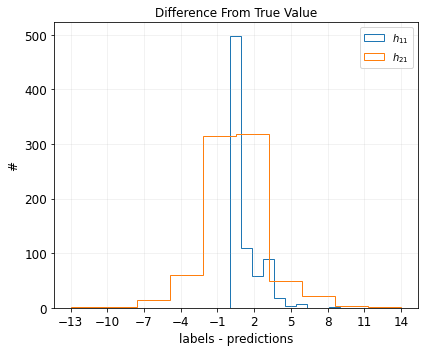

In [12]:
import joblib

from sklearn.linear_model import Lasso
from skopt                import BayesSearchCV
from skopt.space          import Real, Integer
from sklearn.metrics      import make_scorer
from mltools.libscore     import accuracy, Score, ViewCV
from mltools.libplot      import Plot

log.info('Training LASSO.')

rounding = np.floor #----------------------------------------------------------------- choose a rounding function
n_iter   = 10 #----------------------------------------------------------------------- choose the number of CV iterations
scoring  = make_scorer(accuracy, rounding=rounding) #--------------------------------- create a scoring function

params  = {'fit_intercept': Integer(False, True),
           'normalize':     Integer(False, True),
           'positive':      Integer(False, True),
           'alpha':         Real(1.0e-7, 1.0e2, prior='log-uniform')
          } #------------------------------------------------------------------------- build the parameter space
hyper_search = BayesSearchCV(Lasso(max_iter=1.0e5, random_state=RAND),
                             params,
                             scoring=scoring,
                             n_jobs=-1,
                             n_iter=n_iter,
                             refit=True,
                             random_state=RAND,
                             cv=cv) #------------------------------------------------- define hyperparameter tuning

#############################
#                           #
# MATRIX ONLY               #
#                           #
#############################
print('\nMATRIX')
log.info('Training on the matrix dataset.')

hyper_search.fit(matrix_train, h11_train) #------------------------------------------------------- fit matrix on h11

results = ViewCV(hyper_search) #-------------------------------------------------------------------------- read CV results
print('\n    Best parameters for h11: {}'.format(results.best_parameters))
log.info('Best parameters for h11: {}'.format(results.best_parameters)) #--------------------------------- print CV parameters
print('    Accuracy on cross validation for h11: {:.3f}% ± {:.3f}%'.format(results.test_mean()*100,
                                                                         results.test_std()*100
                                                                        )
     )
log.info('Accuracy on CV for h11: {:.3f}% ± {:.3f}%'.format(results.test_mean(),
                                                          results.test_std()
                                                         )
        ) #----------------------------------------------------------------------------------------------- evaluate CV results

predictions = hyper_search.best_estimator_.predict(matrix_test) #----------------------------------------- compute predictions
pred_score_h11  = Score(h11_test, predictions, rounding=rounding)
log.info('Number of correct test predictions for h11: {:d}'.format(pred_score_h11.correct()))
log.info('Accuracy of test predictions for h11: {:.3f}%'.format(pred_score_h11.accuracy()*100))
print('    Accuracy on the test set for h11: {:.3f}%'.format(pred_score_h11.accuracy()*100)) #------------ evaluate predictions

joblib.dump(hyper_search.best_estimator_, path.join(MOD_PATH, 'lasso_mat_h11.joblib')) #------------------ save the model

hyper_search.fit(matrix_train, h21_train) #------------------------------------------------------- fit matrix on h21

results = ViewCV(hyper_search) #-------------------------------------------------------------------------- read CV results
print('\n    Best parameters for h21: {}'.format(results.best_parameters))
log.info('Best parameters for h21: {}'.format(results.best_parameters)) #--------------------------------- print CV parameters
print('    Accuracy on cross validation for h21: {:.3f}% ± {:.3f}%'.format(results.test_mean()*100,
                                                                         results.test_std()*100
                                                                        )
     )
log.info('Accuracy on CV for h21: {:.3f}% ± {:.3f}%'.format(results.test_mean()*100,
                                                          results.test_std()*100
                                                         )
        ) #----------------------------------------------------------------------------------------------- evaluate CV results

predictions = hyper_search.best_estimator_.predict(matrix_test) #----------------------------------------- compute predictions
pred_score_h21  = Score(h21_test, predictions, rounding=rounding)
log.info('Number of correct test predictions for h21: {:d}'.format(pred_score_h21.correct()))
log.info('Accuracy of test predictions for h21: {:.3f}%'.format(pred_score_h21.accuracy()*100))
print('    Accuracy on the test set for h21: {:.3f}%\n'.format(pred_score_h21.accuracy()*100)) #---------- evaluate predictions

joblib.dump(hyper_search.best_estimator_, path.join(MOD_PATH, 'lasso_mat_h21.joblib')) #------------------ save the model

#############################
#                           #
# ENGINEERED FEATURES       #
#                           #
#############################
print('\nENGINEERED FEATURES ONLY')
log.info('Training on the engineered features.')

hyper_search.fit(selection_h11_train, h11_train) #------------------------------------------------ fit set on h11

results = ViewCV(hyper_search) #-------------------------------------------------------------------------- read CV results
print('\n    Best parameters for h11: {}'.format(results.best_parameters))
log.info('Best parameters for h11: {}'.format(results.best_parameters)) #--------------------------------- print CV parameters
print('    Accuracy on cross validation for h11: {:.3f}% ± {:.3f}%'.format(results.test_mean()*100,
                                                                         results.test_std()*100
                                                                        )
     )
log.info('Accuracy on CV for h11: {:.3f}% ± {:.3f}%'.format(results.test_mean()*100,
                                                          results.test_std()*100
                                                         )
        ) #----------------------------------------------------------------------------------------------- evaluate CV results

predictions = hyper_search.best_estimator_.predict(selection_h11_test) #---------------------------------- compute predictions
pred_score_h11  = Score(h11_test, predictions, rounding=rounding)
log.info('Number of correct test predictions for h11: {:d}'.format(pred_score_h11.correct()))
log.info('Accuracy of test predictions for h11: {:.3f}%'.format(pred_score_h11.accuracy()*100))
print('    Accuracy on the test set for h11: {:.3f}%'.format(pred_score_h11.accuracy()*100)) #------------ evaluate predictions

joblib.dump(hyper_search.best_estimator_, path.join(MOD_PATH, 'lasso_sel_h11.joblib')) #------------------ save the model

hyper_search.fit(selection_h21_train, h21_train) #------------------------------------------------ fit set on h21

results = ViewCV(hyper_search) #-------------------------------------------------------------------------- read CV results
print('\n    Best parameters for h21: {}'.format(results.best_parameters))
log.info('Best parameters for h21: {}'.format(results.best_parameters)) #--------------------------------- print CV parameters
print('    Accuracy on cross validation for h21: {:.3f}% ± {:.3f}%'.format(results.test_mean()*100,
                                                                         results.test_std()*100
                                                                        )
     )
log.info('Accuracy on CV for h21: {:.3f}% ± {:.3f}%'.format(results.test_mean()*100,
                                                          results.test_std()*100
                                                         )
        ) #----------------------------------------------------------------------------------------------- evaluate CV results

predictions = hyper_search.best_estimator_.predict(selection_h21_test) #---------------------------------- compute predictions
pred_score_h21  = Score(h21_test, predictions, rounding=rounding)
log.info('Number of correct test predictions for h21: {:d}'.format(pred_score_h21.correct()))
log.info('Accuracy of test predictions for h21: {:.3f}%'.format(pred_score_h21.accuracy()*100))
print('    Accuracy on the test set for h21: {:.3f}%\n'.format(pred_score_h21.accuracy()*100)) #---------- evaluate predictions

joblib.dump(hyper_search.best_estimator_, path.join(MOD_PATH, 'lasso_sel_h21.joblib')) #------------------ save the model

#############################
#                           #
# FULL DATASET              #
#                           #
#############################
print('\nFULL DATASET')
log.info('Training on the full dataset.')

hyper_search.fit(features_h11_train, h11_train) #------------------------------------------------- fit set on h11

results = ViewCV(hyper_search) #-------------------------------------------------------------------------- read CV results
print('\n    Best parameters for h11: {}'.format(results.best_parameters))
log.info('Best parameters for h11: {}'.format(results.best_parameters)) #--------------------------------- print CV parameters
print('    Accuracy on cross validation for h11: {:.3f}% ± {:.3f}%'.format(results.test_mean()*100,
                                                                         results.test_std()*100
                                                                        )
     )
log.info('Accuracy on CV for h11: {:.3f}% ± {:.3f}%'.format(results.test_mean()*100,
                                                          results.test_std()*100
                                                         )
        ) #----------------------------------------------------------------------------------------------- evaluate CV results

predictions = hyper_search.best_estimator_.predict(features_h11_test) #----------------------------------- compute predictions
pred_score_h11  = Score(h11_test, predictions, rounding=rounding)
log.info('Number of correct test predictions for h11: {:d}'.format(pred_score_h11.correct()))
log.info('Accuracy of test predictions for h11: {:.3f}%'.format(pred_score_h11.accuracy()*100))
print('    Accuracy on the test set for h11: {:.3f}%'.format(pred_score_h11.accuracy()*100)) #------------ evaluate predictions

joblib.dump(hyper_search.best_estimator_, path.join(MOD_PATH, 'lasso_eng_h11.joblib')) #------------------ save the model

hyper_search.fit(features_h21_train, h21_train) #------------------------------------------------- fit set on h21

results = ViewCV(hyper_search) #-------------------------------------------------------------------------- read CV results
print('\n    Best parameters for h21: {}'.format(results.best_parameters))
log.info('Best parameters for h21: {}'.format(results.best_parameters)) #--------------------------------- print CV parameters
print('    Accuracy on cross validation for h21: {:.3f}% ± {:.3f}%'.format(results.test_mean()*100,
                                                                         results.test_std()*100
                                                                        )
     )
log.info('Accuracy on CV for h21: {:.3f}% ± {:.3f}%'.format(results.test_mean()*100,
                                                          results.test_std()*100
                                                         )
        ) #----------------------------------------------------------------------------------------------- evaluate CV results

predictions = hyper_search.best_estimator_.predict(features_h21_test) #----------------------------------- compute predictions
pred_score_h21  = Score(h21_test, predictions, rounding=rounding)
log.info('Number of correct test predictions for h21: {:d}'.format(pred_score_h21.correct()))
log.info('Accuracy of test predictions for h21: {:.3f}%'.format(pred_score_h21.accuracy()*100))
print('    Accuracy on the test set for h21: {:.3f}%\n'.format(pred_score_h21.accuracy()*100)) #---------- evaluate predictions

joblib.dump(hyper_search.best_estimator_, path.join(MOD_PATH, 'lasso_eng_h21.joblib')) #------------------ save the model

# plot the error difference as reference
Plot().hist2D(data=pred_score_h11.error(),
              title='Difference From True Value',
              xlabel='labels - predictions',
              ylabel='#',
              legend='$h_{11}$',
              binstep=3
             ).hist2D(data=pred_score_h21.error(),
                      title='Difference From True Value',
                      xlabel='labels - predictions',
                      ylabel='#',
                      legend='$h_{21}$',
                      binstep=3
                     ).save_and_close(path.join(IMG_PATH, 'lasso_error_plot'))

The effects of the engineered features are even more pronounced with the Lasso algorithm: the accuracy of $h_{21}$ is almost doubled when introducing the engineered features and the PCA, while the engineered features by themselves seem to perform best for the algorithm.

## Ridge

We then consider another linear regression model. However with the **Ridge**, we introduce an different parameter of the regularization (**L2** in this case). We will therefore try to optimize:

- _fit_intercept_: True/False,
- _normalize_: True/False,
- _alpha_ (the regularization parameter): uniformly extracted in $\left[ 10^{-7}, 10^2 \right]$.


MATRIX

    Best parameters for h11: OrderedDict([('alpha', 1.5702940115212556), ('fit_intercept', 0), ('normalize', 1)])
    Accuracy on cross validation for h11: 51.564% ± 1.519%
    Accuracy on the test set for h11: 49.491%

    Best parameters for h21: OrderedDict([('alpha', 0.0010080744573676239), ('fit_intercept', 1), ('normalize', 0)])
    Accuracy on cross validation for h21: 11.465% ± 0.985%
    Accuracy on the test set for h21: 8.906%


ENGINEERED FEATURES ONLY

    Best parameters for h11: OrderedDict([('alpha', 3.4394990986855456), ('fit_intercept', 1), ('normalize', 0)])
    Accuracy on cross validation for h11: 52.682% ± 1.415%
    Accuracy on the test set for h11: 52.672%

    Best parameters for h21: OrderedDict([('alpha', 3.4394990986855456), ('fit_intercept', 1), ('normalize', 0)])
    Accuracy on cross validation for h21: 18.358% ± 1.449%
    Accuracy on the test set for h21: 19.466%


FULL DATASET

    Best parameters for h11: OrderedDict([('alpha', 3.4394990986855

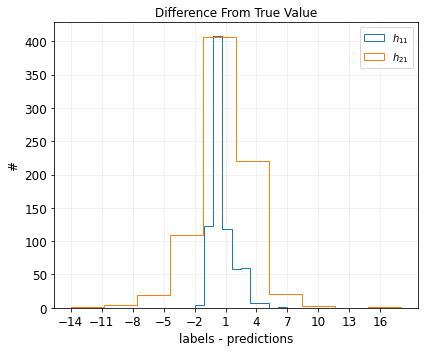

In [13]:
from sklearn.linear_model import Ridge
from skopt                import BayesSearchCV
from skopt.space          import Real, Integer
from sklearn.metrics      import make_scorer
from mltools.libscore     import accuracy, Score, ViewCV
from mltools.libplot      import Plot

log.info('Training RIDGE.')

rounding = np.floor #----------------------------------------------------------------- choose a rounding function
n_iter   = 10 #----------------------------------------------------------------------- choose the number of CV iterations
scoring  = make_scorer(accuracy, rounding=rounding) #--------------------------------- create a scoring function

params  = {'fit_intercept': Integer(False, True),
           'normalize':     Integer(False, True),
           'alpha':         Real(1.0e-7, 1.0e2, prior='log-uniform')
          } #------------------------------------------------------------------------- build the parameter space
hyper_search = BayesSearchCV(Ridge(max_iter=1.0e5, random_state=RAND),
                             params,
                             scoring=scoring,
                             n_jobs=-1,
                             n_iter=n_iter,
                             refit=True,
                             random_state=RAND,
                             cv=cv) #------------------------------------------------- define hyperparameter tuning

#############################
#                           #
# MATRIX ONLY               #
#                           #
#############################
print('\nMATRIX')
log.info('Training on the matrix dataset.')

hyper_search.fit(matrix_train, h11_train) #------------------------------------------------------- fit matrix on h11

results = ViewCV(hyper_search) #-------------------------------------------------------------------------- read CV results
print('\n    Best parameters for h11: {}'.format(results.best_parameters))
log.info('Best parameters for h11: {}'.format(results.best_parameters)) #--------------------------------- print CV parameters
print('    Accuracy on cross validation for h11: {:.3f}% ± {:.3f}%'.format(results.test_mean()*100,
                                                                         results.test_std()*100
                                                                        )
     )
log.info('Accuracy on CV for h11: {:.3f}% ± {:.3f}%'.format(results.test_mean(),
                                                          results.test_std()
                                                         )
        ) #----------------------------------------------------------------------------------------------- evaluate CV results

predictions = hyper_search.best_estimator_.predict(matrix_test) #----------------------------------------- compute predictions
pred_score_h11  = Score(h11_test, predictions, rounding=rounding)
log.info('Number of correct test predictions for h11: {:d}'.format(pred_score_h11.correct()))
log.info('Accuracy of test predictions for h11: {:.3f}%'.format(pred_score_h11.accuracy()*100))
print('    Accuracy on the test set for h11: {:.3f}%'.format(pred_score_h11.accuracy()*100)) #------------ evaluate predictions

joblib.dump(hyper_search.best_estimator_, path.join(MOD_PATH, 'ridge_mat_h11.joblib')) #------------------ save the model

hyper_search.fit(matrix_train, h21_train) #------------------------------------------------------- fit matrix on h21

results = ViewCV(hyper_search) #-------------------------------------------------------------------------- read CV results
print('\n    Best parameters for h21: {}'.format(results.best_parameters))
log.info('Best parameters for h21: {}'.format(results.best_parameters)) #--------------------------------- print CV parameters
print('    Accuracy on cross validation for h21: {:.3f}% ± {:.3f}%'.format(results.test_mean()*100,
                                                                         results.test_std()*100
                                                                        )
     )
log.info('Accuracy on CV for h21: {:.3f}% ± {:.3f}%'.format(results.test_mean()*100,
                                                          results.test_std()*100
                                                         )
        ) #----------------------------------------------------------------------------------------------- evaluate CV results

predictions = hyper_search.best_estimator_.predict(matrix_test) #----------------------------------------- compute predictions
pred_score_h21  = Score(h21_test, predictions, rounding=rounding)
log.info('Number of correct test predictions for h21: {:d}'.format(pred_score_h21.correct()))
log.info('Accuracy of test predictions for h21: {:.3f}%'.format(pred_score_h21.accuracy()*100))
print('    Accuracy on the test set for h21: {:.3f}%\n'.format(pred_score_h21.accuracy()*100)) #---------- evaluate predictions

joblib.dump(hyper_search.best_estimator_, path.join(MOD_PATH, 'ridge_mat_h21.joblib')) #------------------ save the model

#############################
#                           #
# ENGINEERED FEATURES       #
#                           #
#############################
print('\nENGINEERED FEATURES ONLY')
log.info('Training on the engineered features.')

hyper_search.fit(selection_h11_train, h11_train) #------------------------------------------------ fit set on h11

results = ViewCV(hyper_search) #-------------------------------------------------------------------------- read CV results
print('\n    Best parameters for h11: {}'.format(results.best_parameters))
log.info('Best parameters for h11: {}'.format(results.best_parameters)) #--------------------------------- print CV parameters
print('    Accuracy on cross validation for h11: {:.3f}% ± {:.3f}%'.format(results.test_mean()*100,
                                                                         results.test_std()*100
                                                                        )
     )
log.info('Accuracy on CV for h11: {:.3f}% ± {:.3f}%'.format(results.test_mean()*100,
                                                          results.test_std()*100
                                                         )
        ) #----------------------------------------------------------------------------------------------- evaluate CV results

predictions = hyper_search.best_estimator_.predict(selection_h11_test) #---------------------------------- compute predictions
pred_score_h11  = Score(h11_test, predictions, rounding=rounding)
log.info('Number of correct test predictions for h11: {:d}'.format(pred_score_h11.correct()))
log.info('Accuracy of test predictions for h11: {:.3f}%'.format(pred_score_h11.accuracy()*100))
print('    Accuracy on the test set for h11: {:.3f}%'.format(pred_score_h11.accuracy()*100)) #------------ evaluate predictions

joblib.dump(hyper_search.best_estimator_, path.join(MOD_PATH, 'ridge_sel_h11.joblib')) #------------------ save the model

hyper_search.fit(selection_h21_train, h21_train) #------------------------------------------------ fit set on h21

results = ViewCV(hyper_search) #-------------------------------------------------------------------------- read CV results
print('\n    Best parameters for h21: {}'.format(results.best_parameters))
log.info('Best parameters for h21: {}'.format(results.best_parameters)) #--------------------------------- print CV parameters
print('    Accuracy on cross validation for h21: {:.3f}% ± {:.3f}%'.format(results.test_mean()*100,
                                                                         results.test_std()*100
                                                                        )
     )
log.info('Accuracy on CV for h21: {:.3f}% ± {:.3f}%'.format(results.test_mean()*100,
                                                          results.test_std()*100
                                                         )
        ) #----------------------------------------------------------------------------------------------- evaluate CV results

predictions = hyper_search.best_estimator_.predict(selection_h21_test) #---------------------------------- compute predictions
pred_score_h21  = Score(h21_test, predictions, rounding=rounding)
log.info('Number of correct test predictions for h21: {:d}'.format(pred_score_h21.correct()))
log.info('Accuracy of test predictions for h21: {:.3f}%'.format(pred_score_h21.accuracy()*100))
print('    Accuracy on the test set for h21: {:.3f}%\n'.format(pred_score_h21.accuracy()*100)) #---------- evaluate predictions

joblib.dump(hyper_search.best_estimator_, path.join(MOD_PATH, 'ridge_sel_h21.joblib')) #------------------ save the model

#############################
#                           #
# FULL DATASET              #
#                           #
#############################
print('\nFULL DATASET')
log.info('Training on the full dataset.')

hyper_search.fit(features_h11_train, h11_train) #------------------------------------------------- fit set on h11

results = ViewCV(hyper_search) #-------------------------------------------------------------------------- read CV results
print('\n    Best parameters for h11: {}'.format(results.best_parameters))
log.info('Best parameters for h11: {}'.format(results.best_parameters)) #--------------------------------- print CV parameters
print('    Accuracy on cross validation for h11: {:.3f}% ± {:.3f}%'.format(results.test_mean()*100,
                                                                         results.test_std()*100
                                                                        )
     )
log.info('Accuracy on CV for h11: {:.3f}% ± {:.3f}%'.format(results.test_mean()*100,
                                                          results.test_std()*100
                                                         )
        ) #----------------------------------------------------------------------------------------------- evaluate CV results

predictions = hyper_search.best_estimator_.predict(features_h11_test) #----------------------------------- compute predictions
pred_score_h11  = Score(h11_test, predictions, rounding=rounding)
log.info('Number of correct test predictions for h11: {:d}'.format(pred_score_h11.correct()))
log.info('Accuracy of test predictions for h11: {:.3f}%'.format(pred_score_h11.accuracy()*100))
print('    Accuracy on the test set for h11: {:.3f}%'.format(pred_score_h11.accuracy()*100)) #------------ evaluate predictions

joblib.dump(hyper_search.best_estimator_, path.join(MOD_PATH, 'ridge_eng_h11.joblib')) #------------------ save the model

hyper_search.fit(features_h21_train, h21_train) #------------------------------------------------- fit set on h21

results = ViewCV(hyper_search) #-------------------------------------------------------------------------- read CV results
print('\n    Best parameters for h21: {}'.format(results.best_parameters))
log.info('Best parameters for h21: {}'.format(results.best_parameters)) #--------------------------------- print CV parameters
print('    Accuracy on cross validation for h21: {:.3f}% ± {:.3f}%'.format(results.test_mean()*100,
                                                                         results.test_std()*100
                                                                        )
     )
log.info('Accuracy on CV for h21: {:.3f}% ± {:.3f}%'.format(results.test_mean()*100,
                                                          results.test_std()*100
                                                         )
        ) #----------------------------------------------------------------------------------------------- evaluate CV results

predictions = hyper_search.best_estimator_.predict(features_h21_test) #----------------------------------- compute predictions
pred_score_h21  = Score(h21_test, predictions, rounding=rounding)
log.info('Number of correct test predictions for h21: {:d}'.format(pred_score_h21.correct()))
log.info('Accuracy of test predictions for h21: {:.3f}%'.format(pred_score_h21.accuracy()*100))
print('    Accuracy on the test set for h21: {:.3f}%\n'.format(pred_score_h21.accuracy()*100)) #---------- evaluate predictions

joblib.dump(hyper_search.best_estimator_, path.join(MOD_PATH, 'ridge_eng_h21.joblib')) #------------------ save the model

# plot the error difference as reference
Plot().hist2D(data=pred_score_h11.error(),
              title='Difference From True Value',
              xlabel='labels - predictions',
              ylabel='#',
              legend='$h_{11}$',
              binstep=3
             ).hist2D(data=pred_score_h21.error(),
                      title='Difference From True Value',
                      xlabel='labels - predictions',
                      ylabel='#',
                      legend='$h_{21}$',
                      binstep=3
                     ).save_and_close(path.join(IMG_PATH, 'ridge_error_plot'))

## Elastic Net

As a comparison we also try a linear model implementing both **L1** and **L2** regularizations at the same time. In this case the algorithm is controlled by two parameters: _alpha_ and _l1_ratio_. The latter represents the ratio between the two kind of regularizations. We will in fact try to optimize:

- _fit_intercept_: True/False,
- _normalize_: True/False,
- _alpha_ (the regularization parameter): uniformly chosen in $\left[ 10^{-7}, 10^2 \right]$,
- _l1_ratio_ (the amount of **L1** vs **L2** regularization): uniformly extracted in $\left[ 0, 1 \right]$.

N.B.: if the regularization is $a~L1 + b~L2$, then _l1_ratio_ = $\frac{a}{a+b}$ (and $alpha = a + b$).


MATRIX

    Best parameters for h11: OrderedDict([('alpha', 0.0010080744573676239), ('fit_intercept', 1), ('l1_ratio', 0.10485915855270359), ('normalize', 0)])
    Accuracy on cross validation for h11: 51.592% ± 1.669%
    Accuracy on the test set for h11: 49.746%

    Best parameters for h21: OrderedDict([('alpha', 1.0781340574440683e-07), ('fit_intercept', 1), ('l1_ratio', 0.7412827443680273), ('normalize', 0)])
    Accuracy on cross validation for h21: 11.451% ± 0.964%
    Accuracy on the test set for h21: 8.906%


ENGINEERED FEATURES ONLY

    Best parameters for h11: OrderedDict([('alpha', 2.0491035004385), ('fit_intercept', 0), ('l1_ratio', 0.598047077512128), ('normalize', 1)])
    Accuracy on cross validation for h11: 61.911% ± 1.023%
    Accuracy on the test set for h11: 63.359%

    Best parameters for h21: OrderedDict([('alpha', 0.0010080744573676239), ('fit_intercept', 1), ('l1_ratio', 0.10485915855270359), ('normalize', 0)])
    Accuracy on cross validation for h21: 18.27

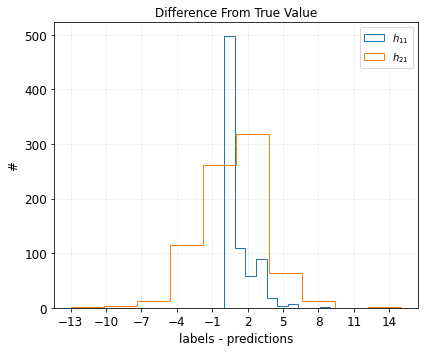

In [14]:
from sklearn.linear_model import ElasticNet
from skopt                import BayesSearchCV
from skopt.space          import Real, Integer
from sklearn.metrics      import make_scorer
from mltools.libscore     import accuracy, Score, ViewCV
from mltools.libplot      import Plot

log.info('Training ELASTIC NET.')

rounding = np.floor #----------------------------------------------------------------- choose a rounding function
n_iter   = 10 #----------------------------------------------------------------------- choose the number of CV iterations
scoring  = make_scorer(accuracy, rounding=rounding) #--------------------------------- create a scoring function

params  = {'fit_intercept': Integer(False, True),
           'normalize':     Integer(False, True),
           'l1_ratio':      Real(0.0, 1.0, prior='uniform'),
           'alpha':         Real(1.0e-7, 1.0e2, prior='log-uniform')
          } #------------------------------------------------------------------------- build the parameter space
hyper_search = BayesSearchCV(ElasticNet(max_iter=1.0e5, random_state=RAND),
                             params,
                             scoring=scoring,
                             n_jobs=-1,
                             n_iter=n_iter,
                             refit=True,
                             random_state=RAND,
                             cv=cv) #------------------------------------------------- define hyperparameter tuning

#############################
#                           #
# MATRIX ONLY               #
#                           #
#############################
print('\nMATRIX')
log.info('Training on the matrix dataset.')

hyper_search.fit(matrix_train, h11_train) #------------------------------------------------------- fit matrix on h11

results = ViewCV(hyper_search) #-------------------------------------------------------------------------- read CV results
print('\n    Best parameters for h11: {}'.format(results.best_parameters))
log.info('Best parameters for h11: {}'.format(results.best_parameters)) #--------------------------------- print CV parameters
print('    Accuracy on cross validation for h11: {:.3f}% ± {:.3f}%'.format(results.test_mean()*100,
                                                                         results.test_std()*100
                                                                        )
     )
log.info('Accuracy on CV for h11: {:.3f}% ± {:.3f}%'.format(results.test_mean(),
                                                          results.test_std()
                                                         )
        ) #----------------------------------------------------------------------------------------------- evaluate CV results

predictions = hyper_search.best_estimator_.predict(matrix_test) #----------------------------------------- compute predictions
pred_score_h11  = Score(h11_test, predictions, rounding=rounding)
log.info('Number of correct test predictions for h11: {:d}'.format(pred_score_h11.correct()))
log.info('Accuracy of test predictions for h11: {:.3f}%'.format(pred_score_h11.accuracy()*100))
print('    Accuracy on the test set for h11: {:.3f}%'.format(pred_score_h11.accuracy()*100)) #------------ evaluate predictions

joblib.dump(hyper_search.best_estimator_, path.join(MOD_PATH, 'el_net_mat_h11.joblib')) #----------------- save the model

hyper_search.fit(matrix_train, h21_train) #------------------------------------------------------- fit matrix on h21

results = ViewCV(hyper_search) #-------------------------------------------------------------------------- read CV results
print('\n    Best parameters for h21: {}'.format(results.best_parameters))
log.info('Best parameters for h21: {}'.format(results.best_parameters)) #--------------------------------- print CV parameters
print('    Accuracy on cross validation for h21: {:.3f}% ± {:.3f}%'.format(results.test_mean()*100,
                                                                         results.test_std()*100
                                                                        )
     )
log.info('Accuracy on CV for h21: {:.3f}% ± {:.3f}%'.format(results.test_mean()*100,
                                                          results.test_std()*100
                                                         )
        ) #----------------------------------------------------------------------------------------------- evaluate CV results

predictions = hyper_search.best_estimator_.predict(matrix_test) #----------------------------------------- compute predictions
pred_score_h21  = Score(h21_test, predictions, rounding=rounding)
log.info('Number of correct test predictions for h21: {:d}'.format(pred_score_h21.correct()))
log.info('Accuracy of test predictions for h21: {:.3f}%'.format(pred_score_h21.accuracy()*100))
print('    Accuracy on the test set for h21: {:.3f}%\n'.format(pred_score_h21.accuracy()*100)) #---------- evaluate predictions

joblib.dump(hyper_search.best_estimator_, path.join(MOD_PATH, 'el_net_mat_h21.joblib')) #----------------- save the model

#############################
#                           #
# ENGINEERED FEATURES       #
#                           #
#############################
print('\nENGINEERED FEATURES ONLY')
log.info('Training on the engineered features.')

hyper_search.fit(selection_h11_train, h11_train) #------------------------------------------------ fit set on h11

results = ViewCV(hyper_search) #-------------------------------------------------------------------------- read CV results
print('\n    Best parameters for h11: {}'.format(results.best_parameters))
log.info('Best parameters for h11: {}'.format(results.best_parameters)) #--------------------------------- print CV parameters
print('    Accuracy on cross validation for h11: {:.3f}% ± {:.3f}%'.format(results.test_mean()*100,
                                                                         results.test_std()*100
                                                                        )
     )
log.info('Accuracy on CV for h11: {:.3f}% ± {:.3f}%'.format(results.test_mean()*100,
                                                          results.test_std()*100
                                                         )
        ) #----------------------------------------------------------------------------------------------- evaluate CV results

predictions = hyper_search.best_estimator_.predict(selection_h11_test) #---------------------------------- compute predictions
pred_score_h11  = Score(h11_test, predictions, rounding=rounding)
log.info('Number of correct test predictions for h11: {:d}'.format(pred_score_h11.correct()))
log.info('Accuracy of test predictions for h11: {:.3f}%'.format(pred_score_h11.accuracy()*100))
print('    Accuracy on the test set for h11: {:.3f}%'.format(pred_score_h11.accuracy()*100)) #------------ evaluate predictions

joblib.dump(hyper_search.best_estimator_, path.join(MOD_PATH, 'el_net_sel_h11.joblib')) #----------------- save the model

hyper_search.fit(selection_h21_train, h21_train) #------------------------------------------------ fit set on h21

results = ViewCV(hyper_search) #-------------------------------------------------------------------------- read CV results
print('\n    Best parameters for h21: {}'.format(results.best_parameters))
log.info('Best parameters for h21: {}'.format(results.best_parameters)) #--------------------------------- print CV parameters
print('    Accuracy on cross validation for h21: {:.3f}% ± {:.3f}%'.format(results.test_mean()*100,
                                                                         results.test_std()*100
                                                                        )
     )
log.info('Accuracy on CV for h21: {:.3f}% ± {:.3f}%'.format(results.test_mean()*100,
                                                          results.test_std()*100
                                                         )
        ) #----------------------------------------------------------------------------------------------- evaluate CV results

predictions = hyper_search.best_estimator_.predict(selection_h21_test) #---------------------------------- compute predictions
pred_score_h21  = Score(h21_test, predictions, rounding=rounding)
log.info('Number of correct test predictions for h21: {:d}'.format(pred_score_h21.correct()))
log.info('Accuracy of test predictions for h21: {:.3f}%'.format(pred_score_h21.accuracy()*100))
print('    Accuracy on the test set for h21: {:.3f}%\n'.format(pred_score_h21.accuracy()*100)) #---------- evaluate predictions

joblib.dump(hyper_search.best_estimator_, path.join(MOD_PATH, 'el_net_sel_h21.joblib')) #----------------- save the model

#############################
#                           #
# FULL DATASET              #
#                           #
#############################
print('\nFULL DATASET')
log.info('Training on the full dataset.')

hyper_search.fit(features_h11_train, h11_train) #------------------------------------------------- fit set on h11

results = ViewCV(hyper_search) #-------------------------------------------------------------------------- read CV results
print('\n    Best parameters for h11: {}'.format(results.best_parameters))
log.info('Best parameters for h11: {}'.format(results.best_parameters)) #--------------------------------- print CV parameters
print('    Accuracy on cross validation for h11: {:.3f}% ± {:.3f}%'.format(results.test_mean()*100,
                                                                         results.test_std()*100
                                                                        )
     )
log.info('Accuracy on CV for h11: {:.3f}% ± {:.3f}%'.format(results.test_mean()*100,
                                                          results.test_std()*100
                                                         )
        ) #----------------------------------------------------------------------------------------------- evaluate CV results

predictions = hyper_search.best_estimator_.predict(features_h11_test) #----------------------------------- compute predictions
pred_score_h11  = Score(h11_test, predictions, rounding=rounding)
log.info('Number of correct test predictions for h11: {:d}'.format(pred_score_h11.correct()))
log.info('Accuracy of test predictions for h11: {:.3f}%'.format(pred_score_h11.accuracy()*100))
print('    Accuracy on the test set for h11: {:.3f}%'.format(pred_score_h11.accuracy()*100)) #------------ evaluate predictions

joblib.dump(hyper_search.best_estimator_, path.join(MOD_PATH, 'el_net_eng_h11.joblib')) #----------------- save the model

hyper_search.fit(features_h21_train, h21_train) #------------------------------------------------- fit set on h21

results = ViewCV(hyper_search) #-------------------------------------------------------------------------- read CV results
print('\n    Best parameters for h21: {}'.format(results.best_parameters))
log.info('Best parameters for h21: {}'.format(results.best_parameters)) #--------------------------------- print CV parameters
print('    Accuracy on cross validation for h21: {:.3f}% ± {:.3f}%'.format(results.test_mean()*100,
                                                                         results.test_std()*100
                                                                        )
     )
log.info('Accuracy on CV for h21: {:.3f}% ± {:.3f}%'.format(results.test_mean()*100,
                                                          results.test_std()*100
                                                         )
        ) #----------------------------------------------------------------------------------------------- evaluate CV results

predictions = hyper_search.best_estimator_.predict(features_h21_test) #----------------------------------- compute predictions
pred_score_h21  = Score(h21_test, predictions, rounding=rounding)
log.info('Number of correct test predictions for h21: {:d}'.format(pred_score_h21.correct()))
log.info('Accuracy of test predictions for h21: {:.3f}%'.format(pred_score_h21.accuracy()*100))
print('    Accuracy on the test set for h21: {:.3f}%\n'.format(pred_score_h21.accuracy()*100)) #---------- evaluate predictions

joblib.dump(hyper_search.best_estimator_, path.join(MOD_PATH, 'el_net_eng_h21.joblib')) #----------------- save the model

# plot the error difference as reference
Plot().hist2D(data=pred_score_h11.error(),
              title='Difference From True Value',
              xlabel='labels - predictions',
              ylabel='#',
              legend='$h_{11}$',
              binstep=3
             ).hist2D(data=pred_score_h21.error(),
                      title='Difference From True Value',
                      xlabel='labels - predictions',
                      ylabel='#',
                      legend='$h_{21}$',
                      binstep=3
                     ).save_and_close(path.join(IMG_PATH, 'el_net_net_error_plot'))

## Linear SVR

We then start to look at a different kind of algorithm. In particular we focus on **support vector machines** and we begin from the linear implementation (i.e. without kernel functions). The number of hyperparameters is higher in this case and we will try to control:

- _C_: uniformly extracted in $\left[ 10^{-2}, 10^2 \right]$,
- _loss_: categorical (_epsilon_insensitive_ or _squared_epsilon_insensitive_),
- _fit_intercept_: True/False,
- _intercept_scaling_: uniformly extracted in $\left[ 10^{-2}, 10^2 \right]$.


MATRIX

    Best parameters for h11: OrderedDict([('C', 17.76576664980768), ('fit_intercept', 0), ('intercept_scaling', 2.467108843522573), ('loss', 'squared_epsilon_insensitive')])
    Accuracy on cross validation for h11: 51.592% ± 1.571%
    Accuracy on the test set for h11: 49.109%

    Best parameters for h21: OrderedDict([('C', 66.36085077612337), ('fit_intercept', 1), ('intercept_scaling', 30.662510776734475), ('loss', 'epsilon_insensitive')])
    Accuracy on cross validation for h21: 11.550% ± 0.938%
    Accuracy on the test set for h21: 10.687%


ENGINEERED FEATURES ONLY

    Best parameters for h11: OrderedDict([('C', 17.76576664980768), ('fit_intercept', 0), ('intercept_scaling', 2.467108843522573), ('loss', 'squared_epsilon_insensitive')])
    Accuracy on cross validation for h11: 52.470% ± 1.455%
    Accuracy on the test set for h11: 52.672%

    Best parameters for h21: OrderedDict([('C', 66.36085077612337), ('fit_intercept', 1), ('intercept_scaling', 30.662510776734475)

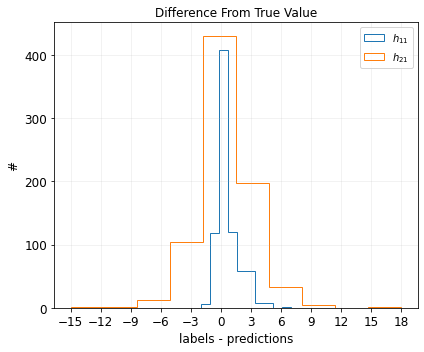

In [15]:
from sklearn.svm      import LinearSVR
from skopt            import BayesSearchCV
from skopt.space      import Real, Integer, Categorical
from sklearn.metrics  import make_scorer
from mltools.libscore import accuracy, Score, ViewCV
from mltools.libplot  import Plot

log.info('Training LINEAR SVR.')

rounding = np.floor #----------------------------------------------------------------- choose a rounding function
n_iter   = 10 #----------------------------------------------------------------------- choose the number of CV iterations
scoring  = make_scorer(accuracy, rounding=rounding) #--------------------------------- create a scoring function

params  = {'fit_intercept':     Integer(False, True),
           'loss':              Categorical(['epsilon_insensitive', 'squared_epsilon_insensitive']),
           'C':                 Real(1.0e-2, 1.0e2, prior='log-uniform'),
           'intercept_scaling': Real(1.0e-2, 1.0e2, prior='log-uniform')
          } #------------------------------------------------------------------------- build the parameter space
hyper_search = BayesSearchCV(LinearSVR(max_iter=1.0e5, random_state=RAND),
                             params,
                             scoring=scoring,
                             n_jobs=-1,
                             n_iter=n_iter,
                             refit=True,
                             random_state=RAND,
                             cv=cv) #------------------------------------------------- define hyperparameter tuning

#############################
#                           #
# MATRIX ONLY               #
#                           #
#############################
print('\nMATRIX')
log.info('Training on the matrix dataset.')

hyper_search.fit(matrix_train, h11_train) #------------------------------------------------------- fit matrix on h11

results = ViewCV(hyper_search) #-------------------------------------------------------------------------- read CV results
print('\n    Best parameters for h11: {}'.format(results.best_parameters))
log.info('Best parameters for h11: {}'.format(results.best_parameters)) #--------------------------------- print CV parameters
print('    Accuracy on cross validation for h11: {:.3f}% ± {:.3f}%'.format(results.test_mean()*100,
                                                                         results.test_std()*100
                                                                        )
     )
log.info('Accuracy on CV for h11: {:.3f}% ± {:.3f}%'.format(results.test_mean(),
                                                          results.test_std()
                                                         )
        ) #----------------------------------------------------------------------------------------------- evaluate CV results

predictions = hyper_search.best_estimator_.predict(matrix_test) #----------------------------------------- compute predictions
pred_score_h11  = Score(h11_test, predictions, rounding=rounding)
log.info('Number of correct test predictions for h11: {:d}'.format(pred_score_h11.correct()))
log.info('Accuracy of test predictions for h11: {:.3f}%'.format(pred_score_h11.accuracy()*100))
print('    Accuracy on the test set for h11: {:.3f}%'.format(pred_score_h11.accuracy()*100)) #------------ evaluate predictions

joblib.dump(hyper_search.best_estimator_, path.join(MOD_PATH, 'el_net_mat_h11.joblib')) #----------------- save the model

hyper_search.fit(matrix_train, h21_train) #------------------------------------------------------- fit matrix on h21

results = ViewCV(hyper_search) #-------------------------------------------------------------------------- read CV results
print('\n    Best parameters for h21: {}'.format(results.best_parameters))
log.info('Best parameters for h21: {}'.format(results.best_parameters)) #--------------------------------- print CV parameters
print('    Accuracy on cross validation for h21: {:.3f}% ± {:.3f}%'.format(results.test_mean()*100,
                                                                         results.test_std()*100
                                                                        )
     )
log.info('Accuracy on CV for h21: {:.3f}% ± {:.3f}%'.format(results.test_mean()*100,
                                                          results.test_std()*100
                                                         )
        ) #----------------------------------------------------------------------------------------------- evaluate CV results

predictions = hyper_search.best_estimator_.predict(matrix_test) #----------------------------------------- compute predictions
pred_score_h21  = Score(h21_test, predictions, rounding=rounding)
log.info('Number of correct test predictions for h21: {:d}'.format(pred_score_h21.correct()))
log.info('Accuracy of test predictions for h21: {:.3f}%'.format(pred_score_h21.accuracy()*100))
print('    Accuracy on the test set for h21: {:.3f}%\n'.format(pred_score_h21.accuracy()*100)) #---------- evaluate predictions

joblib.dump(hyper_search.best_estimator_, path.join(MOD_PATH, 'el_net_mat_h21.joblib')) #----------------- save the model

#############################
#                           #
# ENGINEERED FEATURES       #
#                           #
#############################
print('\nENGINEERED FEATURES ONLY')
log.info('Training on the engineered features.')

hyper_search.fit(selection_h11_train, h11_train) #------------------------------------------------ fit set on h11

results = ViewCV(hyper_search) #-------------------------------------------------------------------------- read CV results
print('\n    Best parameters for h11: {}'.format(results.best_parameters))
log.info('Best parameters for h11: {}'.format(results.best_parameters)) #--------------------------------- print CV parameters
print('    Accuracy on cross validation for h11: {:.3f}% ± {:.3f}%'.format(results.test_mean()*100,
                                                                         results.test_std()*100
                                                                        )
     )
log.info('Accuracy on CV for h11: {:.3f}% ± {:.3f}%'.format(results.test_mean()*100,
                                                          results.test_std()*100
                                                         )
        ) #----------------------------------------------------------------------------------------------- evaluate CV results

predictions = hyper_search.best_estimator_.predict(selection_h11_test) #---------------------------------- compute predictions
pred_score_h11  = Score(h11_test, predictions, rounding=rounding)
log.info('Number of correct test predictions for h11: {:d}'.format(pred_score_h11.correct()))
log.info('Accuracy of test predictions for h11: {:.3f}%'.format(pred_score_h11.accuracy()*100))
print('    Accuracy on the test set for h11: {:.3f}%'.format(pred_score_h11.accuracy()*100)) #------------ evaluate predictions

joblib.dump(hyper_search.best_estimator_, path.join(MOD_PATH, 'el_net_sel_h11.joblib')) #----------------- save the model

hyper_search.fit(selection_h21_train, h21_train) #------------------------------------------------ fit set on h21

results = ViewCV(hyper_search) #-------------------------------------------------------------------------- read CV results
print('\n    Best parameters for h21: {}'.format(results.best_parameters))
log.info('Best parameters for h21: {}'.format(results.best_parameters)) #--------------------------------- print CV parameters
print('    Accuracy on cross validation for h21: {:.3f}% ± {:.3f}%'.format(results.test_mean()*100,
                                                                         results.test_std()*100
                                                                        )
     )
log.info('Accuracy on CV for h21: {:.3f}% ± {:.3f}%'.format(results.test_mean()*100,
                                                          results.test_std()*100
                                                         )
        ) #----------------------------------------------------------------------------------------------- evaluate CV results

predictions = hyper_search.best_estimator_.predict(selection_h21_test) #---------------------------------- compute predictions
pred_score_h21  = Score(h21_test, predictions, rounding=rounding)
log.info('Number of correct test predictions for h21: {:d}'.format(pred_score_h21.correct()))
log.info('Accuracy of test predictions for h21: {:.3f}%'.format(pred_score_h21.accuracy()*100))
print('    Accuracy on the test set for h21: {:.3f}%\n'.format(pred_score_h21.accuracy()*100)) #---------- evaluate predictions

joblib.dump(hyper_search.best_estimator_, path.join(MOD_PATH, 'el_net_sel_h21.joblib')) #----------------- save the model

#############################
#                           #
# FULL DATASET              #
#                           #
#############################
print('\nFULL DATASET')
log.info('Training on the full dataset.')

hyper_search.fit(features_h11_train, h11_train) #------------------------------------------------- fit set on h11

results = ViewCV(hyper_search) #-------------------------------------------------------------------------- read CV results
print('\n    Best parameters for h11: {}'.format(results.best_parameters))
log.info('Best parameters for h11: {}'.format(results.best_parameters)) #--------------------------------- print CV parameters
print('    Accuracy on cross validation for h11: {:.3f}% ± {:.3f}%'.format(results.test_mean()*100,
                                                                         results.test_std()*100
                                                                        )
     )
log.info('Accuracy on CV for h11: {:.3f}% ± {:.3f}%'.format(results.test_mean()*100,
                                                          results.test_std()*100
                                                         )
        ) #----------------------------------------------------------------------------------------------- evaluate CV results

predictions = hyper_search.best_estimator_.predict(features_h11_test) #----------------------------------- compute predictions
pred_score_h11  = Score(h11_test, predictions, rounding=rounding)
log.info('Number of correct test predictions for h11: {:d}'.format(pred_score_h11.correct()))
log.info('Accuracy of test predictions for h11: {:.3f}%'.format(pred_score_h11.accuracy()*100))
print('    Accuracy on the test set for h11: {:.3f}%'.format(pred_score_h11.accuracy()*100)) #------------ evaluate predictions

joblib.dump(hyper_search.best_estimator_, path.join(MOD_PATH, 'el_net_eng_h11.joblib')) #----------------- save the model

hyper_search.fit(features_h21_train, h21_train) #------------------------------------------------- fit set on h21

results = ViewCV(hyper_search) #-------------------------------------------------------------------------- read CV results
print('\n    Best parameters for h21: {}'.format(results.best_parameters))
log.info('Best parameters for h21: {}'.format(results.best_parameters)) #--------------------------------- print CV parameters
print('    Accuracy on cross validation for h21: {:.3f}% ± {:.3f}%'.format(results.test_mean()*100,
                                                                         results.test_std()*100
                                                                        )
     )
log.info('Accuracy on CV for h21: {:.3f}% ± {:.3f}%'.format(results.test_mean()*100,
                                                          results.test_std()*100
                                                         )
        ) #----------------------------------------------------------------------------------------------- evaluate CV results

predictions = hyper_search.best_estimator_.predict(features_h21_test) #----------------------------------- compute predictions
pred_score_h21  = Score(h21_test, predictions, rounding=rounding)
log.info('Number of correct test predictions for h21: {:d}'.format(pred_score_h21.correct()))
log.info('Accuracy of test predictions for h21: {:.3f}%'.format(pred_score_h21.accuracy()*100))
print('    Accuracy on the test set for h21: {:.3f}%\n'.format(pred_score_h21.accuracy()*100)) #---------- evaluate predictions

joblib.dump(hyper_search.best_estimator_, path.join(MOD_PATH, 'el_net_eng_h21.joblib')) #----------------- save the model

# plot the error difference as reference
Plot().hist2D(data=pred_score_h11.error(),
              title='Difference From True Value',
              xlabel='labels - predictions',
              ylabel='#',
              legend='$h_{11}$',
              binstep=3
             ).hist2D(data=pred_score_h21.error(),
                      title='Difference From True Value',
                      xlabel='labels - predictions',
                      ylabel='#',
                      legend='$h_{21}$',
                      binstep=3
                     ).save_and_close(path.join(IMG_PATH, 'el_net_net_error_plot'))